# Equivalent width fitting
This notebook is an example of how to go from measured equivalent widths to abundances.  We'll use the data from [Melendez 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...791...14M/abstract) and redo their differential analysis of iron lines 18 Sco. 

A massive thanks to Emily Griffith for helping translate this to python.

In [1]:
from matplotlib import pyplot as plt
from juliacall import Main as jl
import time
import numpy as np
import pandas as pd

jl.seval("using Korg")
Korg = jl.Korg

## parsing the linelist

In [2]:
# use pandas to read the contents of Table 1, which were downloaded from the journal website
lines = pd.read_csv("Table 1.dat", delim_whitespace=True, skiprows=24,
                    names=["wl", "species", "ExPot", "log_gf", "C6", "EW_18Sco", "EW_Sun"])
lines

,wl,species,ExPot,log_gf,C6,EW_18Sco,EW_Sun
0,5044.211,26.0,2.8512,-2.058,2.710000e-31,74.8,74.3
1,5054.642,26.0,3.6400,-1.921,4.680000e-32,40.9,40.5
2,5127.359,26.0,0.9150,-3.307,1.840000e-32,97.5,96.1
3,5127.679,26.0,0.0520,-6.125,1.200000e-32,18.9,19.1
4,5198.711,26.0,2.2230,-2.135,4.610000e-32,99.3,98.1
...,...,...,...,...,...,...,...
318,3694.810,66.1,0.1030,-0.110,2.800000e+00,17.3,13.9
319,4077.970,66.1,0.1030,-0.040,2.800000e+00,14.8,10.7
320,4103.310,66.1,0.1030,-0.380,2.800000e+00,17.8,15.0
321,4449.700,66.1,0.0000,-1.030,2.800000e+00,4.3,3.3


In [3]:
# convert the numbers in the species column to Korg.Species objects
# jl.broadcast is how you use Julia's broadcasting ("." syntax) from python
# this called Korg.Species on each element in the line.species column
lines.species = jl.broadcast(Korg.Species, lines.species)



In [4]:
# look at Fe lines only, and sort by wavelength
is_iron = [Korg.get_atoms(s) == jl.Vector([26]) for s in lines.species]
lines = lines.loc[is_iron]
lines = lines.sort_values("wl")
lines

,wl,species,ExPot,log_gf,C6,EW_18Sco,EW_Sun
0,5044.211,Fe I,2.8512,-2.058,2.710000e-31,74.8,74.3
1,5054.642,Fe I,3.6400,-1.921,4.680000e-32,40.9,40.5
2,5127.359,Fe I,0.9150,-3.307,1.840000e-32,97.5,96.1
3,5127.679,Fe I,0.0520,-6.125,1.200000e-32,18.9,19.1
86,5197.577,Fe II,3.2306,-2.220,8.690000e-33,84.0,80.7
...,...,...,...,...,...,...,...
81,6810.263,Fe I,4.6070,-0.986,4.500000e-31,53.1,50.6
82,6837.006,Fe I,4.5930,-1.687,2.460000e-32,20.0,18.9
83,6839.830,Fe I,2.5590,-3.350,3.950000e-32,32.5,31.6
84,6843.656,Fe I,4.5480,-0.860,2.940000e-31,64.1,63.3


In [5]:
# to pass the lines to Korg, we need to turn each row of the "lines" dataframe into a Korg.Line object
linelist = jl.broadcast(Korg.Line, lines.wl, # can be in either cm or Å (like these), but NOT nm
                        lines.log_gf,lines.species, # needs to be a Korg.Species, which we handled in the cell above
                        lines.ExPot)

## Set up params for each star

In [6]:
# solar params
sun_Teff, sun_logg, sun_Fe_H, sun_vmic = 5777, 4.44, 0.0, 1.0

# vector of abundances for the sun
sun_A_X = Korg.format_A_X(sun_Fe_H)

# interpolate a model atmosphere for the sun
sun_atm = Korg.interpolate_marcs(sun_Teff, sun_logg, sun_A_X)  

# and likewise for 18 Sco
sco_teff, sco_logg, sco_fe_h, sco_vmic = (5823, 4.45, 0.054, sun_vmic + 0.02)
sco_A_X = Korg.format_A_X(sco_fe_h)
sco_atm = Korg.interpolate_marcs(sco_teff, sco_logg, sco_A_X)

## Calculate the abundances for each star
Because Julia uses "just in time" compilation, the first call to `Korg.Fit.ews_to_abundances` will take several seconds.  The second is much faster, because the code is already compiled.  If you rerun the cell below, both calculations will be fast, even though no data is cached.

In [7]:
# calculate abundances from the EWs for each star

# in order to pass the EWs to Korg.Fit.ews_to_abundances, we convert them to numpy arrays, which 
# are handled automatically, unlike pandas series.  We also wrap the returned julia vector in np.array.
t1 = time.process_time()
lines["A_sun"] = np.array(Korg.Fit.ews_to_abundances(sun_atm, linelist, sun_A_X, np.array(lines.EW_Sun), vmic=sun_vmic))
t2 = time.process_time()
lines["A_18Sco"] = np.array(Korg.Fit.ews_to_abundances(sco_atm, linelist, sco_A_X, np.array(lines.EW_18Sco), vmic=sco_vmic))
t3 = time.process_time()
print(t2-t1)
print(t3-t2)

7.6071089999999995
0.276288000000001


# Plot the results
Plotting as a function of wavelength and equivalenth width is left as an excercise for the reader.

In [8]:
# get a bitmask for the lines of Fe I vs Fe II
neutrals = np.array([spec.charge == 0 for spec in lines.species])

''

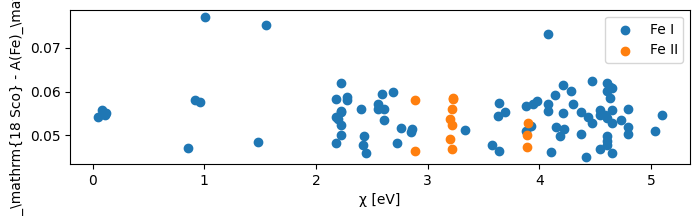

In [9]:
plt.figure(figsize=(8, 2))
plt.scatter(lines.ExPot[neutrals], (lines.A_18Sco - lines.A_sun)[neutrals], label="Fe I")
plt.scatter(lines.ExPot[~neutrals], (lines.A_18Sco - lines.A_sun)[~neutrals], label="Fe II")
plt.ylabel("A(Fe)_\mathrm{18 Sco} - A(Fe)_\mathrm{sun}")
plt.xlabel("χ [eV]")
plt.legend()
;